In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import utils
import aug_functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
data = pd.read_csv('../data/plasticc/good_objects.csv', index_col=0)

data.head()

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
222,13,60532.3019,2,24.529644,1.046373,1,3.790512,0
223,13,60532.3097,1,23.404964,0.992504,1,3.675929,0
224,13,60532.3173,3,36.069386,1.568371,1,3.875155,0
225,13,60532.3282,4,42.765503,2.305008,1,3.938479,0
226,13,60532.3392,5,36.567162,5.439748,1,3.987288,0


In [4]:
good_object_ids = np.unique(data.object_id)

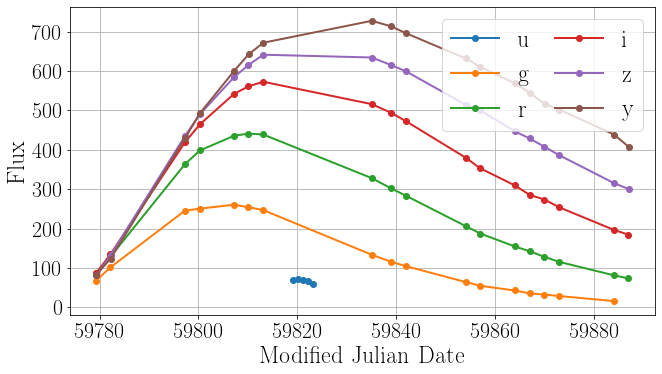

In [5]:
anobject = aug_functions.get_object(data, 34299)

aug_functions.plot_light_curves(anobject)

In [15]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

In [16]:
import features_aug

# fit augmentation model
model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                         anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_pred, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)

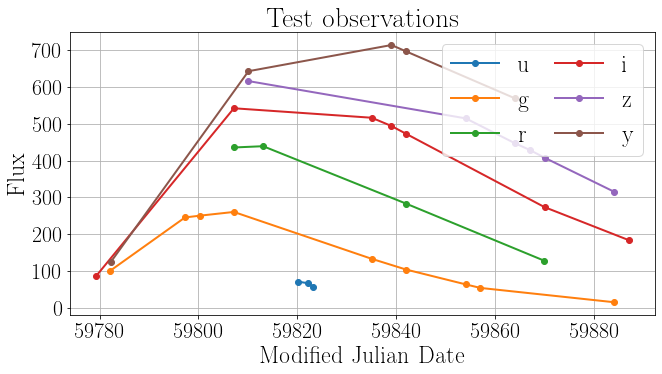

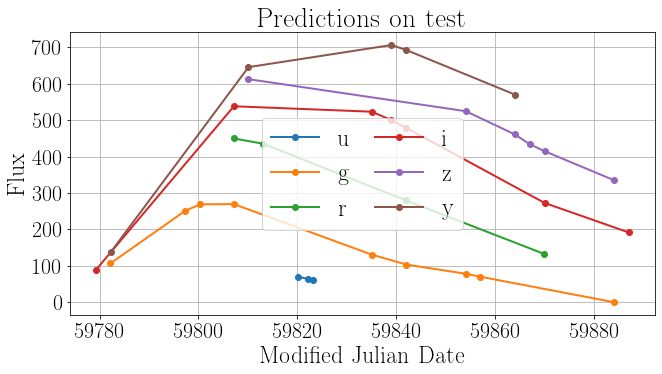

In [17]:
anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, 
                                               flux_pred, anobject_test['passband'].values)
aug_functions.plot_light_curves(anobject_test, "Test observations")
aug_functions.plot_light_curves(anobject_test_pred, "Predictions on test")

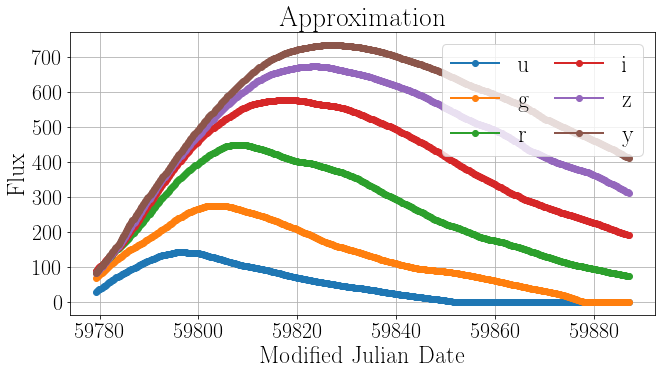

In [18]:
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, passband_aug)
aug_functions.plot_light_curves(anobject_aug, "Approximation")

In [19]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  8.684850021747872
MAE:  7.013365847132065
RSE:  0.04128597320465308
RAE:  0.03744809386686014
MAPE:  6.72783840664512


In [11]:
from tqdm import tqdm
from tqdm import tqdm_notebook

report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for good_id in tqdm_notebook(good_object_ids):
    # get an object
    anobject = aug_functions.get_object(data, good_id)
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)
    
    # fit augmentation model
    model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # augmentation
    t_aug, flux_aug, flux_err_pred, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                      anobject['mjd'].max(), 
                                                                      n_obs=aug_functions.N_OBS)

    anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, flux_pred, 
                                     anobject_test['passband'].values)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                      anobject_test_pred['flux'].values)
    report.loc[len(report), :] = [good_id] + list(metrics)

In [12]:
np.round(report.mean(), 2)

ID      3644745.09
RMSE         21.09
MAE          12.64
RSE           0.32
RAE           0.28
MAPE         18.01
dtype: float64